In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys
from sklearn.cross_validation import cross_val_predict

from sklearn.pipeline import Pipeline

# used for train/test splits and cross validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
#import xgboost as xgb

# default colours for prettier plots

col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

from __future__ import print_function

In [40]:
df.sort_values?

In [41]:
df = pd.read_csv('got_data.csv', sep=',', index_col=0)
# who do we not have data for?
idxNoData = (df['Season(s)'].isnull())

print(df[idxNoData].index)
# delete people with no data - they have no scores and never appeared in season 5
df = df.loc[~idxNoData]
df.sort_values('Total',axis=0,ascending=False).head(n=3).T

Index([u'Arianne_Martel', u'Ben_Plumm', u'Gerold_Dayne_The_Darkstar', u'Griff',
       u'Lady_Stoneheart', u'Reznak_mo_Reznak', u'Ser_Arys_Oakheart',
       u'Young_Griff'],
      dtype='object', name=u'Name')


Name,Grey_Worm,Tyrion_Lannister,Jorah_Mormont
Killing,108,9,72
SexNudity,0,0,0
Insult,0,63,7
Drinking,0,48,6
Injury,68,52,84
Total,176,172,169
Age,NaN,Approx. 38 in Season 6[1],NaN
Allegiance,House TargaryenThe Unsullied,House Lannister (formerly)House Targaryen,House Targaryen (by oath)Varys (formerly)Golde...
Also known as,NaN,The ImpHalfmanThe Little Lion,Jorah the Andal
Appeared in,17 episodes (see below),46 episodes (see below),40 episodes (see below)


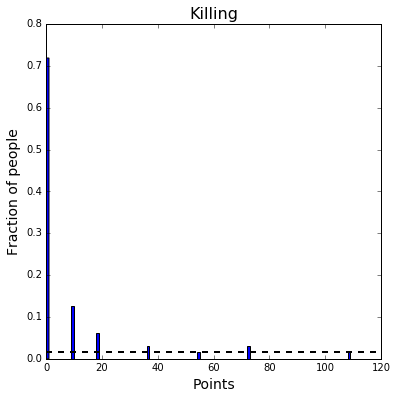

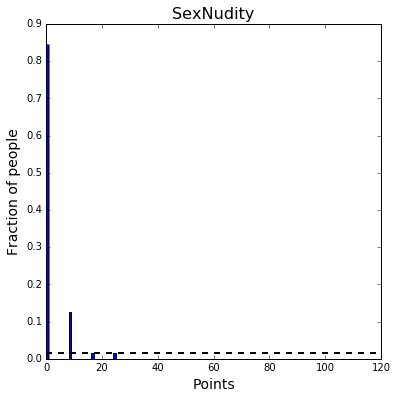

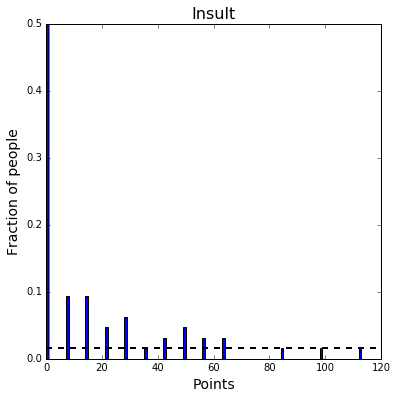

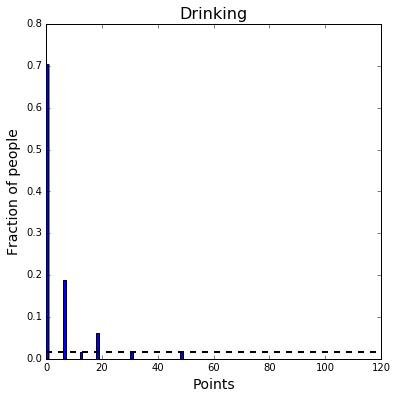

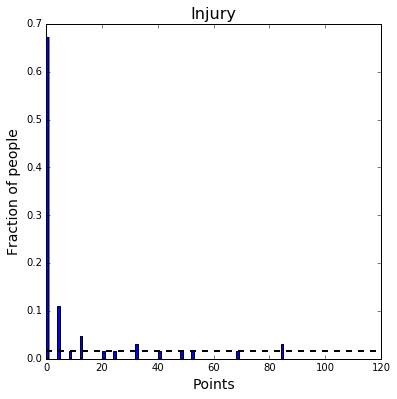

In [15]:
# visualize the data a bit
txt_outcome = ['Killing','SexNudity','Insult','Drinking','Injury']
for txt in txt_outcome:
    plt.figure(figsize=[6,6])
    plt.hist(df[txt],bins=range(120),normed=True)
    plt.plot([0,120], 1.0/df.shape[0]*np.ones(2), 'k--',lw=2 )
    plt.title(txt,fontsize=16)
    plt.xlabel('Points',fontsize=14)
    plt.ylabel('Fraction of people',fontsize=14)
    plt.show()

In [34]:
# calculate the number of words
txt_col = ['Background','Season 1','Season 2', 'Season 3', 'Season 4']
def count_words(s, phrase):
    if s is np.nan:
        return 0
    else:
        return len(re.findall(phrase,s, re.IGNORECASE))

def add_data(df_data, column_name, phrase, txt_col=None):
    if txt_col is None:
        txt_col = ['Background','Season 1','Season 2', 'Season 3', 'Season 4']
        
    df_new = df[txt_col].applymap(lambda x: count_words(x,phrase))
    df_data[column_name] = df_new[txt_col].sum(axis=1)
    return df_data

In [51]:
# we define what columns to look at
# usually it is the below
txt_col = ['Background','Season 1','Season 2', 'Season 3', 'Season 4']

# make a regression on scores using number of words in each season
idxData = np.ones(df.shape[0], dtype=bool)
df_data = df.loc[idxData, ['Total']]

# count the number of hyphens as a surrogate as the number of in-show family member
# in the data, the family members appear as "sister - Sansa Stark, father - Eddard Stark," .. etc
df_data = add_data(df_data, 'family_members',' - ', txt_col = ['Family'])
df_data = add_data(df_data, 'number_of_seasons','[1-5]', txt_col = ['Season(s)'])
df_data = add_data(df_data, 'violent_words','(knight|warrior|sword|axe|spear|kill|murder|fight|assassinate)')
df_data = add_data(df_data, 'sexy_words','(sex|naked|love|slept|nude|kiss)')
df_data = add_data(df_data, 'fun_words','(beer|wine|glass|drunk|inebriate)')
df_data = add_data(df_data, 'number_of_words','\w+')

df_data.drop('Total',axis=1,inplace=True) # get rid of the feature we initialized the dataframe with
df_data.head()

,family_members,number_of_seasons,violent_words,sexy_words,fun_words,number_of_words
Name,,,,,,
Aeron_Greyjoy,8,0,0,0,0,46
Areo_Hotah,0,1,2,0,0,56
Arya_Stark,23,5,57,2,1,4730
Balon_Greyjoy,8,2,6,0,0,1505
Barristan_Selmy,0,4,28,2,2,1895


# logistic regression on target

Since the targets seem to be poorly distributed across the continuous scale (see histograms), we reformulate it from "how many points?" to "are they going to get any points at all?", i.e. a binary prediction task.

lr         0.800556 [0.666667,     1]


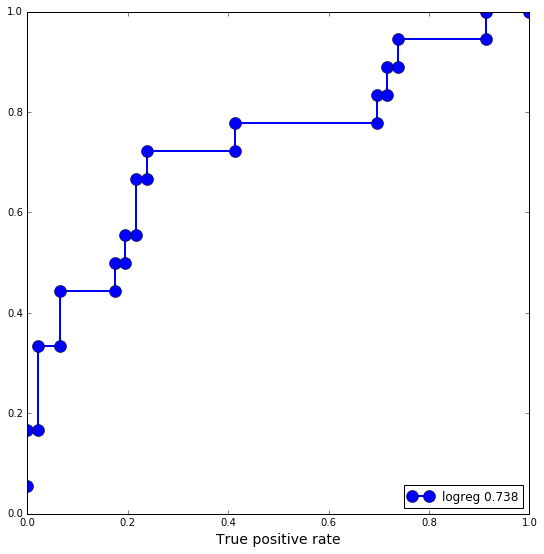

In [55]:
# pull data - first column is the target
X = df_data[idxData].values
target = df['Killing'].values
X = X[:,1:X.shape[1]]
y = target > 0

# workaround cross_val_predict returning 0s/1s - calling this makes it return probabilities
class proba_logreg(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)

# cross-validation performance
mdl = "logreg"
model = LogisticRegression(fit_intercept=True)
estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ("lr", model)])
scores = cross_val_score(estimator, X, y, scoring='roc_auc',cv=5)
print('{:10s} {:5g} [{:5g}, {:5g}]'.format("lr", np.mean(scores), np.min(scores), np.max(scores) ))

# plot a roc curve
predicted = cross_val_predict(proba_logreg(), X, y, cv=10)
predicted = predicted[:,1]

plt.figure(figsize=[9,9])
ax = plt.gca()
fpr, tpr, thresholds = metrics.roc_curve(y, predicted, pos_label=1)
plt.plot(fpr, tpr, 'bo-',lw=2,markersize=12,
        label=mdl + ' ' + '%0.3f' % metrics.auc(fpr, tpr))
plt.xlabel('False positive rate',fontsize=14)
plt.xlabel('True positive rate',fontsize=14)
plt.legend(loc='lower right')
plt.show()

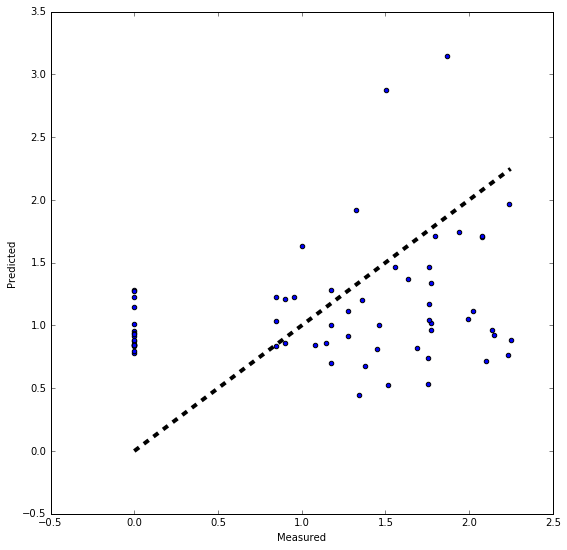

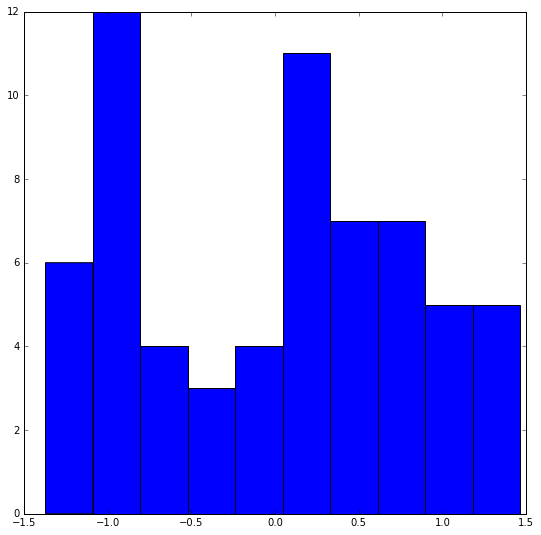

In [44]:
y = np.log10(target+1)
estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])])

predicted = cross_val_predict(LinearRegression(fit_intercept=True), X, y, cv=10)

plt.figure(figsize=[9,9])
ax = plt.gca()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=[9,9])
plt.hist(y - predicted)
plt.show()